# CS 229 Final Project

Authors: Imogen Gardiner, Zofia Dudek, Galen Topper

## Project Overview:

Our project involves building machine learning models to improve the prediction of progression of breast cancer.

In [9]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import roc_auc_score, mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

from utils import datasets, train_and_eval_model, run_hparam_search, hyperparameter_search_logisitc


#### Processing the data

In [3]:
# Read in the dataset
bc_data = pd.read_csv('breast_msk_2018_clinical_data.tsv', sep='\t')
print(bc_data.head())

# Handle NaN values

          Study ID Patient ID          Sample ID    Cancer Type  \
0  breast_msk_2018  P-0000004  P-0000004-T01-IM3  Breast Cancer   
1  breast_msk_2018  P-0000012  P-0000012-T02-IM3  Breast Cancer   
2  breast_msk_2018  P-0000015  P-0000015-T01-IM3  Breast Cancer   
3  breast_msk_2018  P-0000041  P-0000041-T01-IM3  Breast Cancer   
4  breast_msk_2018  P-0000057  P-0000057-T01-IM3  Breast Cancer   

                        Cancer Type Detailed  Disease Free Event  \
0           Breast Invasive Ductal Carcinoma                   1   
1           Breast Invasive Ductal Carcinoma                   0   
2           Breast Invasive Ductal Carcinoma                   1   
3           Breast Invasive Ductal Carcinoma                   1   
4  Breast Mixed Ductal and Lobular Carcinoma                   1   

   Disease Free (Months) ER PCT Primary ER Status of Sequenced Sample  \
0                    1.1             70                      Positive   
1                  218.0              0   

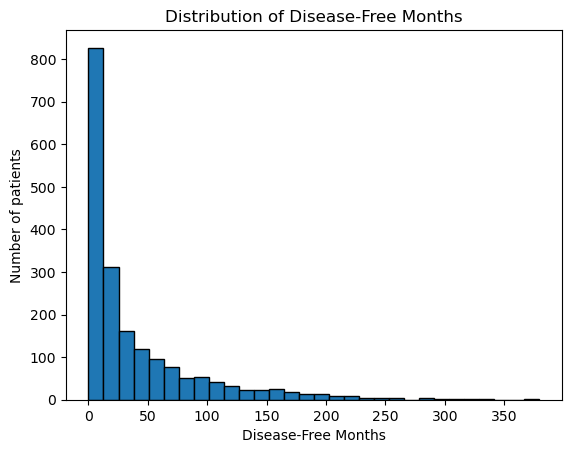

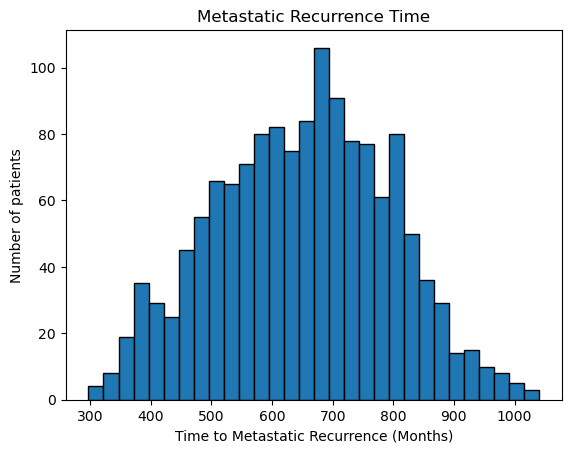

In [4]:
# Visualize the data

# Disease-free months
plt.hist(bc_data['Disease Free (Months)'], bins=30, edgecolor='black')
plt.xlabel('Disease-Free Months')
plt.ylabel('Number of patients')
plt.title('Distribution of Disease-Free Months')
plt.show()

# Metastatic recurrence time
plt.hist(bc_data['Metastatic Recurrence Time'], bins=30, edgecolor='black')
plt.xlabel('Time to Metastatic Recurrence (Months)')
plt.ylabel('Number of patients')
plt.title('Metastatic Recurrence Time')
plt.show()


In [5]:
# Split data into train, valid, test sets

train_idx, valid_idx, test_idx = None, None, None 

train_idx, test_idx = train_test_split(bc_data.index, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.2, train_size=0.8, random_state=0, shuffle=True, stratify=None)

In [6]:
# Now, split up features and labels
ds_instance = datasets(
    train_X = bc_data.loc[train_idx],
    valid_X = bc_data.loc[valid_idx],
    test_X = bc_data.loc[test_idx],
    train_y = bc_data.loc[train_idx, "Metastatic Recurrence Time"],
    valid_y = bc_data.loc[valid_idx, "Metastatic Recurrence Time"],
    test_y = bc_data.loc[test_idx, "Metastatic Recurrence Time"],
    )


In [7]:
print(bc_data.dtypes)
print(bc_data["HER2 IHC Score of Sequenced Sample"].unique())
print(bc_data["PR PCT Primary"].unique())


Study ID                                          object
Patient ID                                        object
Sample ID                                         object
Cancer Type                                       object
Cancer Type Detailed                              object
Disease Free Event                                 int64
Disease Free (Months)                            float64
ER PCT Primary                                    object
ER Status of Sequenced Sample                     object
ER Status of the Primary                          object
Fraction Genome Altered                          float64
HER2 FISH Status of Sequenced Sample              object
HER2 FISH Ratio Value of Sequenced Sample         object
HER2 FISH Ratio Primary                           object
HER2 FISH Status (Report and ASCO) of Primary     object
HER2 IHC Status Primary                           object
HER2 IHC Score of Sequenced Sample                object
HER2 IHC Status of Sequenced Sa

#### Training a linear regression model

In [13]:
y = bc_data["Metastatic Recurrence Time"].dropna()
X = bc_data

# Align X and y
X = X.loc[y.index].reset_index(drop=True)
y = y.reset_index(drop=True)

# Encode categorical variables
categorical_columns = X.select_dtypes(include=["object"]).columns
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X[categorical_columns] = encoder.fit_transform(X[categorical_columns])

# Ensure all remaining features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

def hyperparameter_search_linear(X_train, y_train, param_grid, inner_cv):
    """
    Perform hyperparameter tuning for linear regression using GridSearchCV.
    """
    model = Pipeline([
        ("scaler", StandardScaler()),  
        ("feature_selection", SelectKBest(score_func=f_regression)),  
        ("regressor", Ridge())  # Default to Ridge, change to Lasso if needed
    ])

    search = GridSearchCV(model, param_grid, cv=inner_cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
    search.fit(X_train, y_train)

    return {"best_params": search.best_params_, "best_score": -search.best_score_} # convert negative RMSE to RMSE

param_grid = {
    "feature_selection__k": [10, 15, 20, 25, 30, 35, 40, 45, 50, 55],  
    "regressor": [Ridge(), Lasso(alpha=10, max_iter=5000)],  
    "regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]  
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_train_scores = []
rmse_test_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ensure all values are numeric
    X_train = pd.DataFrame(X_train).apply(pd.to_numeric, errors='coerce')
    X_test = pd.DataFrame(X_test).apply(pd.to_numeric, errors='coerce')
    y_train = pd.to_numeric(y_train, errors='coerce')

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Convert back to DataFrame (optional, for better readability)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

    # Apply mean imputation to the target variable (y_train) if needed
    y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Hyperparameter tuning using inner cross-validation
    search_results = hyperparameter_search_linear(X_train, y_train, param_grid, inner_cv=5)
    best_params = search_results["best_params"]
    print(f"Best Params (Inner CV): {best_params}, Best Validation RMSE: {search_results['best_score']:.4f}")

    # Use SelectKBest with best k found during hyperparameter search
    selector = SelectKBest(score_func=f_regression, k=best_params["feature_selection__k"])
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Get selected feature names
    selected_features = X.columns[selector.get_support()]
    print(f"Top {best_params['feature_selection__k']} selected features: {list(selected_features)}")

    # Train final model with best hyperparameters
    best_model = best_params["regressor"].set_params(alpha=best_params["regressor__alpha"])
    best_model.fit(X_train_selected, y_train)

    # Predictions using selected features
    y_train_pred = best_model.predict(X_train_selected)
    y_test_pred = best_model.predict(X_test_selected)

    # Compute RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_train_scores.append(train_rmse)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_test_scores.append(test_rmse)

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

# Report final results
print(f"Mean Train RMSE: {np.mean(rmse_train_scores):.4f}")
print(f"Mean Test RMSE: {np.mean(rmse_test_scores):.4f}")

Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(), 'regressor__alpha': 0.001}, Best Validation RMSE: 0.1488
Top 10 selected features: ['Disease Free (Months)', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Last Communication Contact', 'Menopausal Status At Diagnosis', 'Mutation Count', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Time To Death (Months)', 'TMB (nonsynonymous)']
Training RMSE: 0.2862
Test RMSE: 0.3017


/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(alpha=0.001), 'regressor__alpha': 0.001}, Best Validation RMSE: 0.2469
Top 10 selected features: ['Disease Free (Months)', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Last Communication Contact', 'Menopausal Status At Diagnosis', 'Metastatic Recurrence Time', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Time To Death (Months)', 'TMB (nonsynonymous)']
Training RMSE: 0.0462
Test RMSE: 0.0438


/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(alpha=0.001), 'regressor__alpha': 0.001}, Best Validation RMSE: 0.1036
Top 10 selected features: ['Disease Free (Months)', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Last Communication Contact', 'Menopausal Status At Diagnosis', 'Mutation Count', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Time To Death (Months)', 'TMB (nonsynonymous)']
Training RMSE: 0.2871
Test RMSE: 0.2974


/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(alpha=0.001), 'regressor__alpha': 0.001}, Best Validation RMSE: 0.2425
Top 10 selected features: ['Disease Free (Months)', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Last Communication Contact', 'Menopausal Status At Diagnosis', 'Metastatic Recurrence Time', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Time To Death (Months)', 'TMB (nonsynonymous)']
Training RMSE: 0.0467
Test RMSE: 0.0486
Best Params (Inner CV): {'feature_selection__k': 10, 'regressor': Ridge(alpha=0.001), 'regressor__alpha': 0.001}, Best Validation RMSE: 0.1970
Top 10 selected features: ['Disease Free (Months)', 'Invasive Carcinoma Diagnosis Age', 'Time to Diagnosis Invasive Carcinoma', 'Last Communication Contact', 'Menopausal Status At Diagnosis', 'Metastatic Recurrence Time', 'NGS Sample Collection Time Period', 'Overall Survival (Months)', 'Time To Death (Months)', 'TMB (nonsynonymous)']


/Users/imogengardiner/anaconda3/envs/202env/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Plot linear regression model 

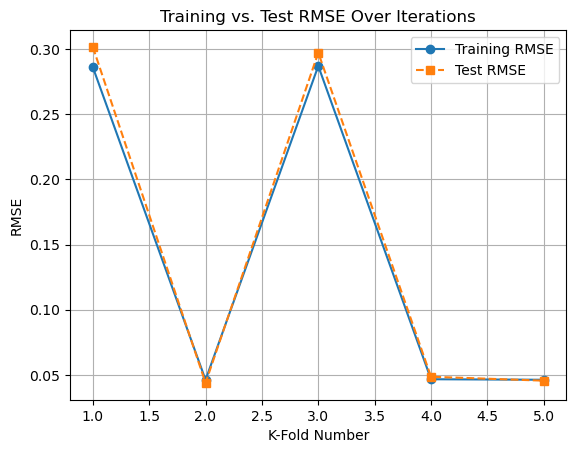

In [14]:
# Create an iteration index (e.g., fold numbers)
iterations = range(1, len(rmse_train_scores) + 1)

# Plot Training RMSE
plt.plot(iterations, rmse_train_scores, label="Training RMSE", marker='o', linestyle='-')

# Plot Test RMSE
plt.plot(iterations, rmse_test_scores, label="Test RMSE", marker='s', linestyle='--')

# Formatting the plot
plt.xlabel("K-Fold Number")
plt.ylabel("RMSE")
plt.title("Training vs. Test RMSE Over Iterations")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Training an XGBoost model
We have many missing values, which XGBoost can handle well.

Metrics: {'train': 0.45185138266888114, 'valid': 92.33603284407312, 'test': 86.9274697431041}


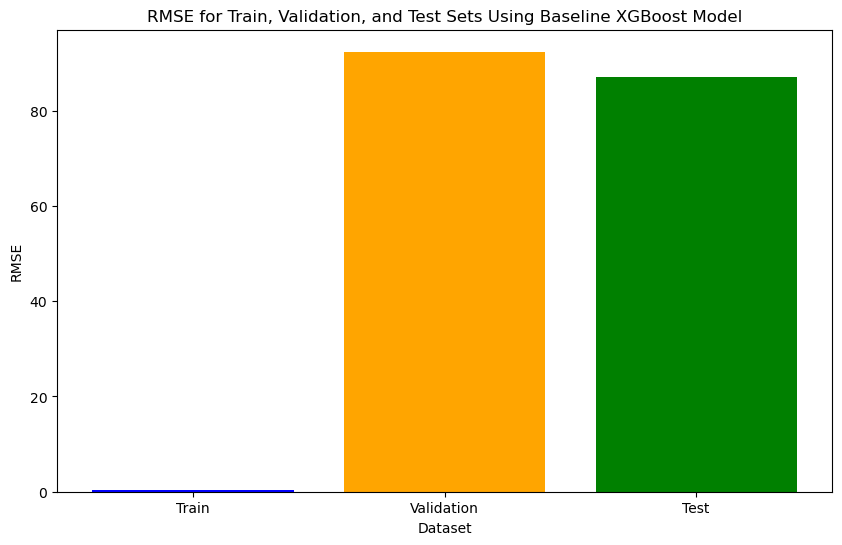

In [12]:
# Handle categorical features
categorical_features = ds_instance.train_X.select_dtypes(include=["object"]).columns

for col in categorical_features:
    ds_instance.train_X[col] = ds_instance.train_X[col].astype("category")
    ds_instance.valid_X[col] = ds_instance.valid_X[col].astype("category")
    ds_instance.test_X[col] = ds_instance.test_X[col].astype("category")

# Define XGBoost model
XGB_model = XGBRegressor(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=5, enable_categorical=True)

# Define features to include
features_to_include = ["Cancer Type", "Cancer Type Detailed", "Disease Free Event", "Disease Free (Months)", "ER PCT Primary", 
                       "ER Status of Sequenced Sample", "ER Status of the Primary", "Fraction Genome Altered", "HER2 FISH Status of Sequenced Sample", 
                       "HER2 FISH Ratio Value of Sequenced Sample", "HER2 FISH Ratio Primary", "HER2 FISH Status (Report and ASCO) of Primary", 
                       "HER2 IHC Status Primary", "HER2 IHC Score of Sequenced Sample", "HER2 IHC Status of Sequenced Sample", "HER2 IHC Score Primary", 
                       "HER2 Primary Status", "Overall HR Status of Sequenced Sample", "Invasive Carcinoma Diagnosis Age", 
                       "Time to Diagnosis Invasive Carcinoma", "Last Communication Contact", "Primary Tumor Laterality", "M Stage", 
                       "Menopausal Status At Diagnosis", "Metastatic Disease at Last Follow-up", "Mutation Count", 
                       "N Stage", "NGS Sample Collection Time Period", "Oncotree Code", "Overall Survival (Months)", "Overall Survival Status", 
                       "Overall HER2 Status of Sequenced Sample", "Overall Patient HER2 Status", "Overall Patient HR Status", 
                       "Overall Patient Receptor Status", "Overall Primary Tumor Grade", "PR PCT Primary", "PR Status of Sequenced Sample", 
                       "PR Status of the Primary", "Primary Nuclear Grade", "Prior Breast Primary", "Prior Local Recurrence", "Receptor Status Primary", 
                       "Number of Samples Per Patient", "Site of Sample", "Sample Type", "Sex", "Somatic Status", "Stage At Diagnosis", "T Stage", 
                       "Time To Death (Months)", "TMB (nonsynonymous)", "Tumor Sample Histology", "Tumor Tissue Origin", "Patient's Vital Status"]

# Remove rows with NaN values in the features to include
ds_instance.train_X = ds_instance.train_X[features_to_include].dropna()
ds_instance.valid_X = ds_instance.valid_X[features_to_include].dropna()
ds_instance.test_X = ds_instance.test_X[features_to_include].dropna()

# Ensure the target variable has no NaN values
ds_instance.train_y = ds_instance.train_y[ds_instance.train_X.index]
ds_instance.valid_y = ds_instance.valid_y[ds_instance.valid_X.index]
ds_instance.test_y = ds_instance.test_y[ds_instance.test_X.index]

# Train and evaluate XGBoost model
predictions, metrics = train_and_eval_model(model=XGB_model, ds=ds_instance, features_to_include=features_to_include)

# Report metrics
print("Metrics:", metrics)

# Plot metrics
# Extract the metrics
train_rmse = metrics['train']
valid_rmse = metrics['valid']
test_rmse = metrics['test']

# Create a bar plot
labels = ['Train', 'Validation', 'Test']
rmse_values = [train_rmse, valid_rmse, test_rmse]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_values, color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('RMSE')
plt.title('RMSE for Train, Validation, and Test Sets Using Baseline XGBoost Model')
plt.show()

#### Addressing overfitting
To address overfitting, we will run a hyperparameter search and retrain the model on the best hyperparameters found.

In [13]:
# Remove categorical features from the dataset (TODO: figure out how to handle categorical features)
ds_instance.train_X = ds_instance.train_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.valid_X = ds_instance.valid_X.select_dtypes(include=["int", "float", "bool"])
ds_instance.test_X = ds_instance.test_X.select_dtypes(include=["int", "float", "bool"])

# Update features_to_include to only include numerical features
features_to_include = ds_instance.train_X.columns.tolist()

print(len(features_to_include))

# Run a hyperparameter search
best_metrics, best_params = run_hparam_search(ds=ds_instance, features_to_include=features_to_include)

# Report best hyperparameters and model performance
print("Best Hyperparameters Found:", best_params)
print("Best Metrics Found:", best_metrics)


12


TypeError: xgboost.sklearn.XGBRegressor() got multiple values for keyword argument 'enable_categorical'

#### Training a CNN

In [ ]:
# Code to train CNN



#### Evaluating the CNN

In [ ]:
# Code to evaluate CNN model

# Confusion matrix

In [ ]:
# Code to run a hyperparameter search for the CNN